# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.2 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.3 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-1g_zu236
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-1g_zu236
  Resolved https://github.com/huggingface/accelerate to commit b30a349078d5301411e8af421720eaa60e984fa2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.22.0.dev0-py3-none-any.whl size=250102 sha256=cd26fc8355264df25571cc6552de8a156840e0110662b2e6389f7da8c98210c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-7g39ndfe/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [4]:
# !pip install huggingface_hub

# Load data and pre-processing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [7]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
df_p = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_P.csv")
df_r = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_R.csv")

R_4_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/R_4_attack.csv.csv")
R_2_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/R_2_attack.csv")
R_1_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/R_1_attack.csv")

#P
P_3_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/P_3_attack.csv")
P_1_attack=pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/P_1_attack.csv")
P_perception_attack=pd.read_csv('/content/drive/MyDrive/thesis_project_files/main_label/P_perception_attack.csv')


In [9]:
df_p = df_p.drop(['Duration', 'comment', 'Role','combine'], axis=1)
df_r = df_r.drop(['Duration', 'comment', 'Role','combine'], axis=1)

In [10]:
df_r = df_r.rename(columns={"Label":"label", "clean_text":"text"})
df_p = df_p.rename(columns={"Label":"label", "clean_text":"text"})

In [11]:
R_4_attack=R_4_attack.drop(['Unnamed: 0'],axis=1)
R_2_attack=R_2_attack.drop(['Unnamed: 0'],axis=1)
R_1_attack=R_1_attack.drop(['Unnamed: 0'],axis=1)

P_3_attack=P_3_attack.drop(['Unnamed: 0'],axis=1)
P_1_attack=P_1_attack.drop(['Unnamed: 0'],axis=1)
P_perception_attack=P_perception_attack.drop(['Unnamed: 0'],axis=1)

In [12]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [13]:
def exclude(df, labels):
  exclude_idx=[]
  for d in range(0, len(df['label'])):
    if df['label'][d] not in labels:
      exclude_idx.append(d)
  return df.drop(index=(exclude_idx))


df_r=exclude(df_r, R_labels)
df_p=exclude(df_p, P_labels)

In [14]:
df_r_train=pd.concat([R_4_attack,R_2_attack,R_1_attack])
df_p_train=pd.concat([P_3_attack,P_1_attack,P_perception_attack])

In [15]:
#P_labels=['information','design action', 'failure action','failure reasoning', 'perception']

def convert_p(label):
  label=str(label)
  if label=='information':
      return 0
  elif label=='design action':
      return 1
  elif label=='failure action':
      return 2
  elif label=='failure reasoning':
      return 3
  else:
      return 4

df_p['index']=df_p['label'].apply(convert_p)
df_p_train['index']=df_p_train['label'].apply(convert_p)

In [16]:
#R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

def convert(label):
  label=str(label)
  if label=='introduction':
      return 0
  elif label=='clarification':
      return 1
  elif label=='workshop management':
      return 2
  elif label=='implementation':
      return 3
  else:
      return 4

df_r['index']=df_r['label'].apply(convert)
df_r_train['index']=df_r_train['label'].apply(convert)

In [17]:
df_r_train.groupby(['label']).size()

label
clarification     605
failure           786
implementation    691
introduction      723
dtype: int64

In [18]:
df_p_train.groupby(['label']).size()

label
failure action    390
information       240
perception        359
dtype: int64

# Model

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [20]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [21]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['text'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [22]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [23]:
import torch
torch.cuda.empty_cache()

In [24]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Researcher

In [25]:
# R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']
import random
# Return a list of indices
intro_idx=random.sample(list(df_r_train.query('label=="introduction"').index), 10)
cl_idx=random.sample(list(df_r_train.query('label=="clarification"').index),10)
work_idx=random.sample(list(df_r.query('label=="workshop management"').index),10)
imp_idx=random.sample(list(df_r_train.query('label=="implementation"').index),10)
fail_idx=random.sample(list(df_r_train.query('label=="failure"').index),10)

# Use indices to select data
work=df_r.loc[work_idx]
other= df_r_train.loc[intro_idx + cl_idx + imp_idx + fail_idx]
train_r = pd.concat([work,other])

In [26]:
test_r=df_r.drop(index=(work_idx))
valid_r, test_r = train_test_split(df_r, test_size=0.8)

In [27]:
train_data_loader_r = create_data_loader(train_r, tokenizer, max_len=128, batch_size=16)
val_data_loader_r = create_data_loader(valid_r, tokenizer, max_len=128, batch_size=16)
test_data_loader_r = create_data_loader(test_r, tokenizer, max_len=128, batch_size=16)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [29]:
# define parameters
EPOCHS = 20

model = Classifier(len(R_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_r) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_r))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [30]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader_r)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.689773576600211 accuracy 0.1619047619047619


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.7755143847958794 accuracy 1.2095238095238097

Epoch 2/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 1.5481070961271013 accuracy 0.24761904761904763


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.0013485489220453 accuracy 0.5047619047619049

Epoch 3/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 1.59328716141837 accuracy 0.2285714285714286


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.0303175983757806 accuracy 1.1238095238095238

Epoch 4/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 1.4943503141403198 accuracy 0.36190476190476195


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.8083102744201134 accuracy 0.8857142857142858

Epoch 5/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 1.1825241616794042 accuracy 0.5714285714285715


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.782900070321971 accuracy 1.1238095238095238

Epoch 6/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.7799442325319562 accuracy 0.761904761904762


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.6636991377534538 accuracy 1.5142857142857145

Epoch 7/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.49936353095940184 accuracy 0.8571428571428572


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.9277561533040013 accuracy 1.5142857142857145

Epoch 8/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.33209589017289026 accuracy 0.8571428571428572


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.5662273250777146 accuracy 1.885714285714286

Epoch 9/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.13386883293943747 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.6328104405567563 accuracy 2.066666666666667

Epoch 10/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.059719322116247246 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.763367800877012 accuracy 2.0

Epoch 11/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.02835928216310484 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.7693475628721302 accuracy 2.161904761904762

Epoch 12/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.01645262965134212 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.845360200980614 accuracy 2.161904761904762

Epoch 13/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.008889858743974141 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.9291594788945954 accuracy 2.180952380952381

Epoch 14/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.007255117575238858 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.9698984705168625 accuracy 2.1714285714285717

Epoch 15/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.005951658822596073 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.9855050136303078 accuracy 2.161904761904762

Epoch 16/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.005088358884677291 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.9976076668706433 accuracy 2.1714285714285717

Epoch 17/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.004677008870722992 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.0155144272179437 accuracy 2.180952380952381

Epoch 18/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.0046738502902111834 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.0301118266993554 accuracy 2.180952380952381

Epoch 19/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.004108477749728731 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.037069779017876 accuracy 2.180952380952381

Epoch 20/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.0040446189564785785 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 2.0392543940708556 accuracy 2.180952380952381



In [31]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader_r)

In [32]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.4252726379824395

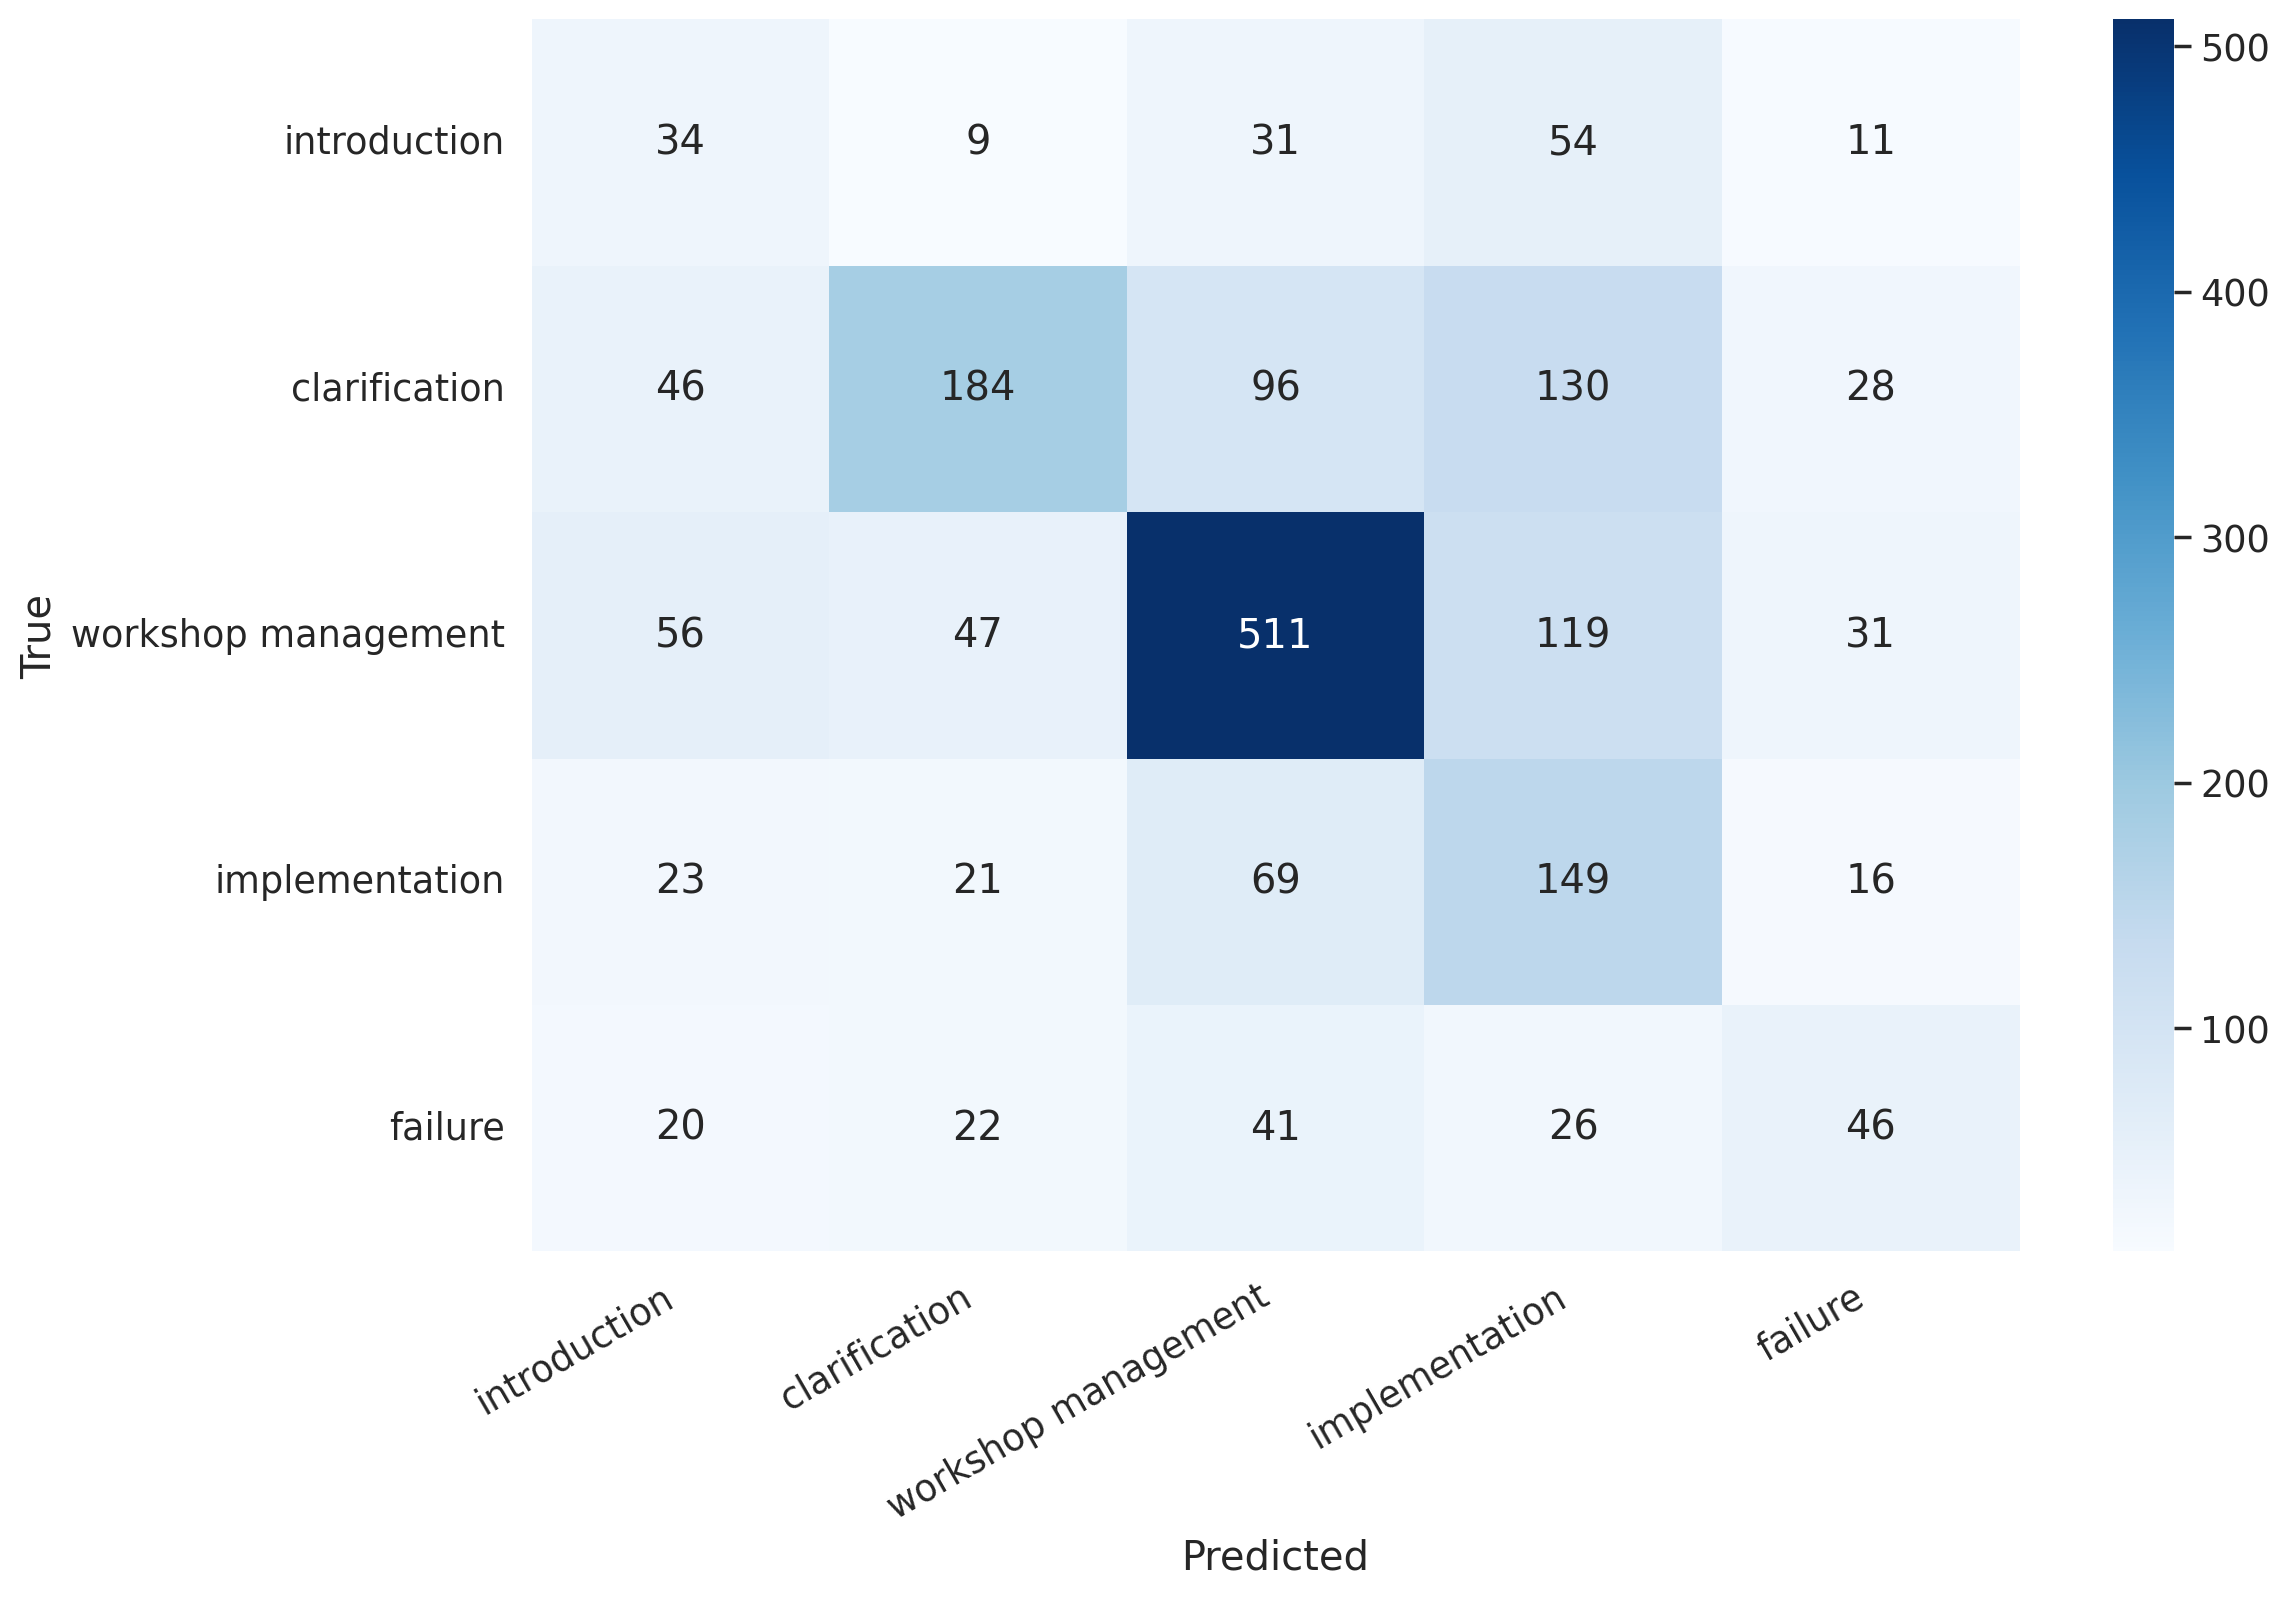

In [33]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [34]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.19      0.24      0.21       139
      clarification       0.65      0.38      0.48       484
workshop management       0.68      0.67      0.68       764
     implementation       0.31      0.54      0.39       278
            failure       0.35      0.30      0.32       155

           accuracy                           0.51      1820
          macro avg       0.44      0.43      0.42      1820
       weighted avg       0.55      0.51      0.52      1820



# Participant

In [35]:
import random
# Return a list of indices
info_idx=random.sample(list(df_p_train.query('label=="information"').index),10)
des_idx=random.sample(list(df_p.query('label=="design action"').index),10)
fa1_idx=random.sample(list(df_p_train.query('label=="failure action"').index),10)
fa2_idx=random.sample(list(df_p.query('label=="failure reasoning"').index),10)
per_idx=random.sample(list(df_p_train.query('label=="perception"').index),10)

# Use indices to select data
p_index=df_p.loc[des_idx + fa2_idx]
others=df_p_train.loc[info_idx+fa1_idx+per_idx]
train_p = pd.concat([p_index, others])

In [36]:
test_p=df_p.drop(index=(des_idx + fa2_idx))
valid_p, test_r = train_test_split(df_p, test_size=0.5)

In [37]:
train_data_loader_p = create_data_loader(train_p, tokenizer, max_len=128, batch_size=16)
val_data_loader_p = create_data_loader(valid_p, tokenizer, max_len=128, batch_size=16)
test_data_loader_p = create_data_loader(test_p, tokenizer, max_len=128, batch_size=16)

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [39]:
# define parameters
EPOCHS = 20

model = Classifier(len(P_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_p) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

P_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_p))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [40]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = P_model_train.train_epoch(train_data_loader_p)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = P_model_train.eval_model(val_data_loader_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.678821325302124 accuracy 0.19417475728155337


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.7566031447628088 accuracy 1.4757281553398056

Epoch 2/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 1.4009057794298445 accuracy 0.37864077669902907


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.1492452767857335 accuracy 1.1262135922330097

Epoch 3/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 1.303184109074729 accuracy 0.4368932038834951


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.3002713918685913 accuracy 1.7281553398058251

Epoch 4/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.9539303524153573 accuracy 0.7087378640776698


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.562652587890625 accuracy 1.2524271844660193

Epoch 5/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.6961395485060555 accuracy 0.7572815533980581


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.2168602692453483 accuracy 2.0970873786407767

Epoch 6/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.43621700682810377 accuracy 0.8737864077669902


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.0945727323230945 accuracy 2.5631067961165046

Epoch 7/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.27435738859432085 accuracy 0.9029126213592232


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.2063907499898945 accuracy 2.6310679611650483

Epoch 8/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.15529528353363276 accuracy 0.9805825242718446


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.4995021694584896 accuracy 2.4757281553398056

Epoch 9/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.09858260556523289 accuracy 0.9902912621359222


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.0812133613385653 accuracy 2.8640776699029122

Epoch 10/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.060474683730197806 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.221281049544351 accuracy 3.019417475728155

Epoch 11/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.04608265410310456 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.6354331426453173 accuracy 2.844660194174757

Epoch 12/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.03879151493310928 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.826889207488612 accuracy 2.7961165048543686

Epoch 13/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.02251035108097962 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.4869328109841597 accuracy 2.8252427184466016

Epoch 14/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.017852334239120995 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.449104957413255 accuracy 2.87378640776699

Epoch 15/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.012952593687389578 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.5122847389756586 accuracy 2.8932038834951452

Epoch 16/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.010209491742508752 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.548492297791598 accuracy 2.8834951456310676

Epoch 17/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.008645958533244473 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.5376037003701195 accuracy 2.8932038834951452

Epoch 18/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.010410530243201979 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.5151043607477557 accuracy 2.8932038834951452

Epoch 19/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.008499138788985354 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.5146875820661845 accuracy 2.902912621359223

Epoch 20/20
----------


  0%|          | 0/7 [00:00<?, ?it/s]

Train loss 0.0075679910535525 accuracy 0.9999999999999999


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 2.5209399942766155 accuracy 2.9126213592233006



In [41]:
y_texts, y_pred, y_pred_probs, y_test = P_model_train.get_predictions(test_data_loader_p)

In [42]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.3164934855315146

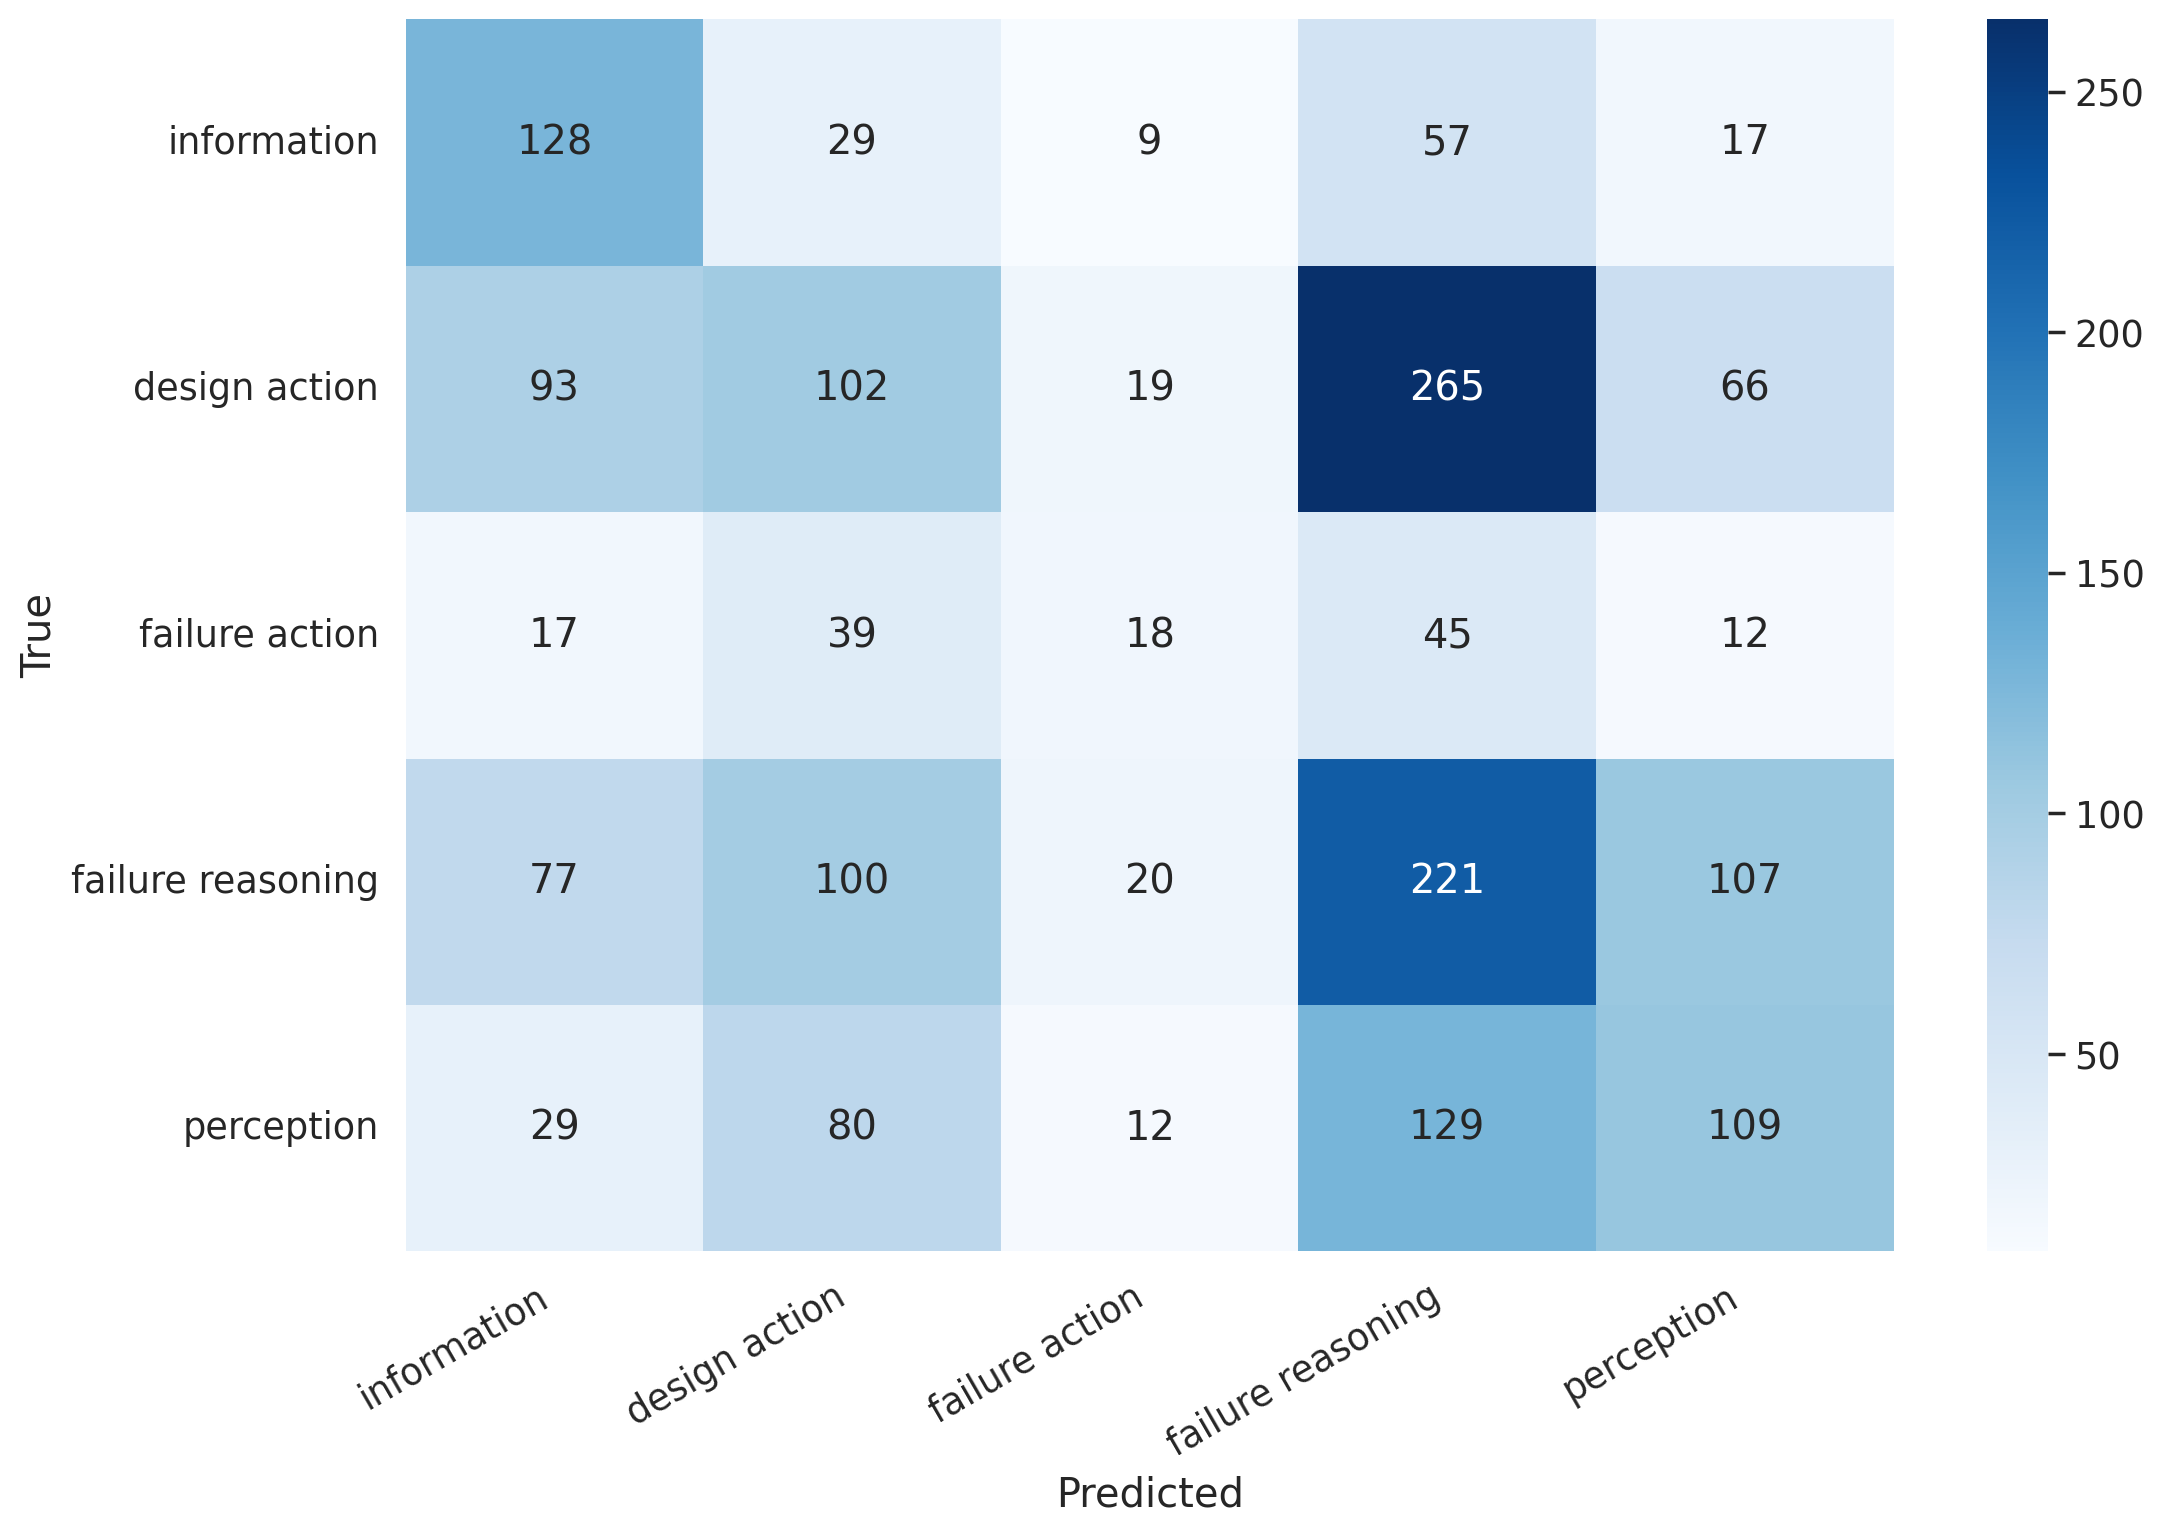

In [43]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [44]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.37      0.53      0.44       240
    design action       0.29      0.19      0.23       545
   failure action       0.23      0.14      0.17       131
failure reasoning       0.31      0.42      0.36       525
       perception       0.35      0.30      0.33       359

         accuracy                           0.32      1800
        macro avg       0.31      0.32      0.30      1800
     weighted avg       0.31      0.32      0.31      1800

